In [1]:
# Protein Embedding Project Skeleton
# Requirements: esm, pandas, scikit-learn, matplotlib, umap-learn

import torch
import esm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import umap
import numpy as np


In [2]:
import requests

def fetch_uniprot_fasta(query, number=10):
    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta&size={number}"
    response = requests.get(url)
    if response.status_code == 200:
        with open("uniprot_sequences.fasta", "w") as f:
            f.write(response.text)
        print(f"Downloaded {number} sequences for: {query}")
    else:
        print("Failed to fetch data:", response.status_code)

# Example: all human kinases
fetch_uniprot_fasta("organism_id:9606 AND family:kinase", number=50)


Downloaded 50 sequences for: organism_id:9606 AND family:kinase


In [3]:

from Bio import SeqIO
sequences = []
for record in SeqIO.parse("uniprot_sequences.fasta", "fasta"):
    sequences.append((record.id, str(record.seq)))


In [4]:
# === 1. Load lightweight ESM model ===
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # Smallest model
batch_converter = alphabet.get_batch_converter()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data = sequences

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [5]:

MAX_LEN = 512  # Optional truncation to avoid long sequences
embeddings = []
labels = [0, 1]  # Dummy labels for example

# === 3. Embed sequences one-by-one to save RAM ===
for seq_id, seq in data:
    if len(seq) > MAX_LEN:
        seq = seq[:MAX_LEN]
    batch_labels, batch_strs, batch_tokens = batch_converter([(seq_id, seq)])
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=False)
    token_representations = results["representations"][6]
    emb = token_representations[0, 1:len(seq)+1].mean(0)
    embeddings.append(emb.cpu().numpy())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-7-1129353ebf9f>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap="Spectral", s=50)


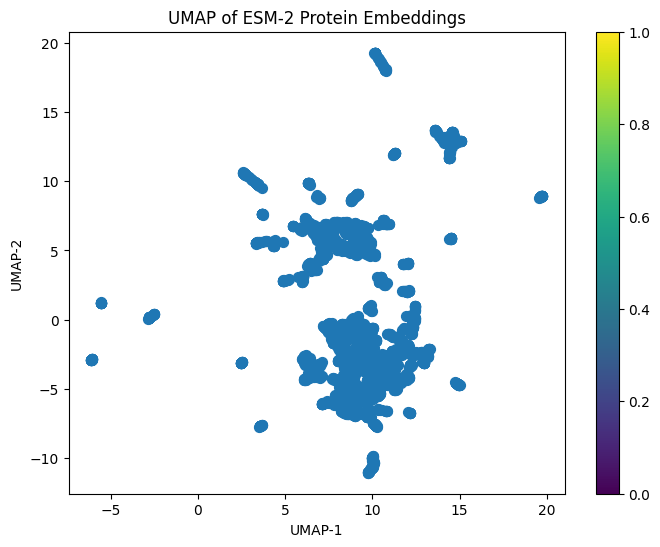

ValueError: Found input variables with inconsistent numbers of samples: [2389, 2]

In [7]:
embeddings = np.stack(embeddings)

# === 4. UMAP / PCA visualization ===
reducer = umap.UMAP()
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], cmap="Spectral", s=50)
plt.title("UMAP of ESM-2 Protein Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar()
plt.show()

# === 5. Classification ===
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


In [4]:
!git config --global user.email "dennis00@ucsb.edu"
!git config --global user.name "Dennis"


In [ ]:
!mv /content/ESM1b_prediction.ipynb.ipynb /content/y/

In [10]:
!pwd

/content


In [6]:
import os

In [9]:
os.getcwd()

'/content'